# Phase 1 - Ingestion and Cleaning

In the Phase 2 of the Case Study, we will carry out the following steps:
  - Ingest raw downloaded data
  - Output a combined dataset ready for analysis and modeling

In [1]:
import pandas as pd
import os
from sys import platform
import matplotlib.pyplot as plt
import datetime
import numpy as np
import pickle
import seaborn
import glob

In [2]:
# A helper function that you'll be using while reading the raw files
def is_integer(x):
    '''
    This function returns True if x is an integer, and False otherwise
    '''
    try:
        return (int(x) == float(x))
    except:
        return False

## Parameters

In [4]:
# Define the directories that contain the files downloaded
dir_cs = "C:\\Users\\amand\\2_MLPS\\Case Study\\case_study_data\\1805_download\\" # path to the directory where all the *.csv.zip files are located

# Define the output path for the pickle
pickle_file = "C:\\Users\\amand\\2_MLPS\\Case Study\\phase-2\\" + "pre_clean_data.pickle" # path to save cleaned data

In [6]:
# Identify the columns we'll be keeping from the dataset
cols_to_pick = ["id", "loan_amnt","funded_amnt", "funded_amnt_inv", "term", "int_rate", "installment", "grade", "sub_grade", 
                "emp_length", "home_ownership", 
                "annual_inc", "verification_status", "issue_d", "loan_status", "purpose", "title", "zip_code", 
                "addr_state", "dti", "total_pymnt", "delinq_2yrs", 
                "earliest_cr_line", "open_acc", "pub_rec", "last_pymnt_d", "last_pymnt_amnt", "fico_range_high", "fico_range_low", 
                "last_fico_range_high", "last_fico_range_low", "application_type", "revol_bal", "revol_util", 
                "recoveries"] # list of features to use for this study as indicated in the handout

# Identify the type of each of these column based on your CS-Phase 1 response
float_cols = ["loan_amnt", "funded_amnt", "installment", "annual_inc", "dti", "delinq_2yrs", "open_acc", "pub_rec", 
             "fico_range_high", "fico_range_low", "revol_bal", "total_pymnt", "recoveries", "funded_amnt_inv",
             "last_fico_range_high", "last_fico_range_low", "last_pymnt_amnt"]
cat_cols = ["term", "grade", "emp_length", "home_ownership", "verification_status", "loan_status", "purpose", 
            "sub_grade", "title", "zip_code", "addr_state", "application_type"] # categorical features
perc_cols = ["int_rate", "revol_util"]
date_cols = ["issue_d", "earliest_cr_line", "last_pymnt_d"]

# Ensure that we have types for every column
assert set(cols_to_pick) - set(float_cols) - set(cat_cols) - set(perc_cols) - set(date_cols) == set(["id"])

In [7]:
# Some of the columns selected will not be used directly in the model,
# but will be used to generate other features.
#
# Create variables specifying the features that will be used

# All categorical columns other than "loan_status" will be used as
# discrete features

discrete_features = list(set(cat_cols) - set(["loan_status"]))

# All numeric columns will be used as continuous features
continuous_features = list(float_cols + perc_cols)

## Ingestion
Ingest the data files from both sets, perform consistency checks, and prepare one single file for each set

In [8]:
def ingest_files(directory):
    '''
    This function will ingest every file in the specified directory
    into a pandas dataframe. It will return a dictionary containing
    these dataframes, keyed by the file name.
    
    We assume the directory contains files directly downloaded from
    the link given in the handout, and *only* those files. Thus, we 
    assume the files are zipped (pd.read_csv can read zipped files) 
    and we assume the first line in each file needs to be skipped.
    
    Note that each file will be read *without* formatting
    '''
    
    # If the directory has no trailing slash, add one
    if directory[-1] != "/":
        directory += "/"
    
    all_files = glob.glob(dir_cs + '/*.zip') # get list of all files from the directory
    output = {}
    
    print("Directory " + directory + " has " + str(len(all_files)) + " files:")
    for i in all_files:
        print("    Reading file " + i)     
        output[i] = pd.read_csv(i, dtype='str', skiprows=1) # read each with dtype='str' and skip_rows =1
        
        # Some of the files have "summary" lines that, for example
        # read "Total number of loans number in Policy 1: ....."
        # To remove those lines, find any lines with non-integer IDs
        # and remove them
    
        invalid_rows = []
        valid_rows = []
        for index, row in output.get(i).iterrows():
            invalid_rows.append(not is_integer(row["id"]))
            valid_rows.append(is_integer(row["id"]))

        if sum(invalid_rows) > 0:
            print("Found " + str(sum(invalid_rows)) + " invalid rows which were removed")
            output[i] = output.get(i)[valid_rows]
    
    return output

In [9]:
# Ingest the set of files we downloaded using the defined method "ingest_files"
files_cs = ingest_files(dir_cs) # dictionary of (filename, dataframe) as (key, value)

Directory C:\Users\amand\2_MLPS\Case Study\case_study_data\1805_download\/ has 12 files:
    Reading file C:\Users\amand\2_MLPS\Case Study\case_study_data\1805_download\LoanStats3a_securev1.csv.zip
Found 3 invalid rows which were removed
    Reading file C:\Users\amand\2_MLPS\Case Study\case_study_data\1805_download\LoanStats3b_securev1.csv.zip
Found 2 invalid rows which were removed
    Reading file C:\Users\amand\2_MLPS\Case Study\case_study_data\1805_download\LoanStats3c_securev1.csv.zip
Found 2 invalid rows which were removed
    Reading file C:\Users\amand\2_MLPS\Case Study\case_study_data\1805_download\LoanStats3d_securev1.csv.zip
Found 2 invalid rows which were removed
    Reading file C:\Users\amand\2_MLPS\Case Study\case_study_data\1805_download\LoanStats_securev1_2016Q1.csv.zip
Found 2 invalid rows which were removed
    Reading file C:\Users\amand\2_MLPS\Case Study\case_study_data\1805_download\LoanStats_securev1_2016Q2.csv.zip
Found 2 invalid rows which were removed
    Rea

### Combine the files

In [10]:
data_cs = pd.concat(files_cs.values())
data_cs.reset_index(drop=True)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,1077501,NaN,5000,5000,4975,36 months,10.65%,162.87,B,B2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,NaN,2500,2500,2500,60 months,15.27%,59.83,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,NaN,2400,2400,2400,36 months,15.96%,84.33,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,NaN,10000,10000,10000,36 months,13.49%,339.31,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,NaN,3000,3000,3000,60 months,12.69%,67.79,B,B5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
5,1075269,NaN,5000,5000,5000,36 months,7.90%,156.46,A,A4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
6,1069639,NaN,7000,7000,7000,60 months,15.96%,170.08,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
7,1072053,NaN,3000,3000,3000,36 months,18.64%,109.43,E,E1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
8,1071795,NaN,5600,5600,5600,60 months,21.28%,152.39,F,F2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
9,1071570,NaN,5375,5375,5350,60 months,12.69%,121.45,B,B5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


## Prepare Final Dataset

In [11]:
# Keep only the columns of interest from 'data_cs'
final_data = data_cs[cols_to_pick]
final_data

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,...,last_pymnt_d,last_pymnt_amnt,fico_range_high,fico_range_low,last_fico_range_high,last_fico_range_low,application_type,revol_bal,revol_util,recoveries
0,1077501,5000,5000,4975,36 months,10.65%,162.87,B,B2,10+ years,...,Jan-2015,171.62,739,735,719,715,Individual,13648,83.7%,0.0
1,1077430,2500,2500,2500,60 months,15.27%,59.83,C,C4,< 1 year,...,Apr-2013,119.66,744,740,499,0,Individual,1687,9.4%,122.9
2,1077175,2400,2400,2400,36 months,15.96%,84.33,C,C5,10+ years,...,Jun-2014,649.91,739,735,739,735,Individual,2956,98.5%,0.0
3,1076863,10000,10000,10000,36 months,13.49%,339.31,C,C1,10+ years,...,Jan-2015,357.48,694,690,604,600,Individual,5598,21%,0.0
4,1075358,3000,3000,3000,60 months,12.69%,67.79,B,B5,1 year,...,Jan-2017,67.3,699,695,684,680,Individual,27783,53.9%,0.0
5,1075269,5000,5000,5000,36 months,7.90%,156.46,A,A4,3 years,...,Jan-2015,161.03,734,730,564,560,Individual,7963,28.3%,0.0
6,1069639,7000,7000,7000,60 months,15.96%,170.08,C,C5,8 years,...,May-2016,1313.76,694,690,654,650,Individual,17726,85.6%,0.0
7,1072053,3000,3000,3000,36 months,18.64%,109.43,E,E1,9 years,...,Jan-2015,111.34,664,660,689,685,Individual,8221,87.5%,0.0
8,1071795,5600,5600,5600,60 months,21.28%,152.39,F,F2,4 years,...,Apr-2012,152.39,679,675,499,0,Individual,5210,32.6%,190.54
9,1071570,5375,5375,5350,60 months,12.69%,121.45,B,B5,< 1 year,...,Nov-2012,121.45,729,725,504,500,Individual,9279,36.5%,277.69


In [12]:
print("Starting with " + str(len(final_data)) + " rows")

Starting with 1765426 rows


### Typecast the columns

In [13]:
# Remember that we read the data as string (without any formatting). 
# Now we would typecast the columns based on feature types which you found out in CS Phase 1

for i in float_cols:
    final_data[i] = final_data[i].astype(float)

C:\Users\amand\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [14]:
def clean_perc(x):
    if pd.isnull(x):
        return np.nan
    else:
        return float(x.strip()[:-1])

for i in perc_cols:
    final_data[i] = final_data[i].apply(lambda x: clean_perc(x)) # apply clean_perc to percentage columns

C:\Users\amand\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [15]:
final_data

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,...,last_pymnt_d,last_pymnt_amnt,fico_range_high,fico_range_low,last_fico_range_high,last_fico_range_low,application_type,revol_bal,revol_util,recoveries
0,1077501,5000.0,5000.0,4975.000000,36 months,10.65,162.87,B,B2,10+ years,...,Jan-2015,171.62,739.0,735.0,719.0,715.0,Individual,13648.0,83.70,0.00
1,1077430,2500.0,2500.0,2500.000000,60 months,15.27,59.83,C,C4,< 1 year,...,Apr-2013,119.66,744.0,740.0,499.0,0.0,Individual,1687.0,9.40,122.90
2,1077175,2400.0,2400.0,2400.000000,36 months,15.96,84.33,C,C5,10+ years,...,Jun-2014,649.91,739.0,735.0,739.0,735.0,Individual,2956.0,98.50,0.00
3,1076863,10000.0,10000.0,10000.000000,36 months,13.49,339.31,C,C1,10+ years,...,Jan-2015,357.48,694.0,690.0,604.0,600.0,Individual,5598.0,21.00,0.00
4,1075358,3000.0,3000.0,3000.000000,60 months,12.69,67.79,B,B5,1 year,...,Jan-2017,67.30,699.0,695.0,684.0,680.0,Individual,27783.0,53.90,0.00
5,1075269,5000.0,5000.0,5000.000000,36 months,7.90,156.46,A,A4,3 years,...,Jan-2015,161.03,734.0,730.0,564.0,560.0,Individual,7963.0,28.30,0.00
6,1069639,7000.0,7000.0,7000.000000,60 months,15.96,170.08,C,C5,8 years,...,May-2016,1313.76,694.0,690.0,654.0,650.0,Individual,17726.0,85.60,0.00
7,1072053,3000.0,3000.0,3000.000000,36 months,18.64,109.43,E,E1,9 years,...,Jan-2015,111.34,664.0,660.0,689.0,685.0,Individual,8221.0,87.50,0.00
8,1071795,5600.0,5600.0,5600.000000,60 months,21.28,152.39,F,F2,4 years,...,Apr-2012,152.39,679.0,675.0,499.0,0.0,Individual,5210.0,32.60,190.54
9,1071570,5375.0,5375.0,5350.000000,60 months,12.69,121.45,B,B5,< 1 year,...,Nov-2012,121.45,729.0,725.0,504.0,500.0,Individual,9279.0,36.50,277.69


In [16]:
def clean_date(x):
    if pd.isnull(x):
        return None
    else:
        return datetime.datetime.strptime( x, "%b-%Y").date()

for i in date_cols:
    final_data[i] = final_data[i].apply(lambda x: clean_date(x)) # typecast date cloumns to datatime using clean_date

C:\Users\amand\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [17]:
final_data

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,...,last_pymnt_d,last_pymnt_amnt,fico_range_high,fico_range_low,last_fico_range_high,last_fico_range_low,application_type,revol_bal,revol_util,recoveries
0,1077501,5000.0,5000.0,4975.000000,36 months,10.65,162.87,B,B2,10+ years,...,2015-01-01,171.62,739.0,735.0,719.0,715.0,Individual,13648.0,83.70,0.00
1,1077430,2500.0,2500.0,2500.000000,60 months,15.27,59.83,C,C4,< 1 year,...,2013-04-01,119.66,744.0,740.0,499.0,0.0,Individual,1687.0,9.40,122.90
2,1077175,2400.0,2400.0,2400.000000,36 months,15.96,84.33,C,C5,10+ years,...,2014-06-01,649.91,739.0,735.0,739.0,735.0,Individual,2956.0,98.50,0.00
3,1076863,10000.0,10000.0,10000.000000,36 months,13.49,339.31,C,C1,10+ years,...,2015-01-01,357.48,694.0,690.0,604.0,600.0,Individual,5598.0,21.00,0.00
4,1075358,3000.0,3000.0,3000.000000,60 months,12.69,67.79,B,B5,1 year,...,2017-01-01,67.30,699.0,695.0,684.0,680.0,Individual,27783.0,53.90,0.00
5,1075269,5000.0,5000.0,5000.000000,36 months,7.90,156.46,A,A4,3 years,...,2015-01-01,161.03,734.0,730.0,564.0,560.0,Individual,7963.0,28.30,0.00
6,1069639,7000.0,7000.0,7000.000000,60 months,15.96,170.08,C,C5,8 years,...,2016-05-01,1313.76,694.0,690.0,654.0,650.0,Individual,17726.0,85.60,0.00
7,1072053,3000.0,3000.0,3000.000000,36 months,18.64,109.43,E,E1,9 years,...,2015-01-01,111.34,664.0,660.0,689.0,685.0,Individual,8221.0,87.50,0.00
8,1071795,5600.0,5600.0,5600.000000,60 months,21.28,152.39,F,F2,4 years,...,2012-04-01,152.39,679.0,675.0,499.0,0.0,Individual,5210.0,32.60,190.54
9,1071570,5375.0,5375.0,5350.000000,60 months,12.69,121.45,B,B5,< 1 year,...,2012-11-01,121.45,729.0,725.0,504.0,500.0,Individual,9279.0,36.50,277.69


In [18]:
for i in cat_cols:
    final_data[i] = final_data[i].fillna(value="None") # for categorical features if the value is null/empty set it to None

C:\Users\amand\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [19]:
final_data

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,...,last_pymnt_d,last_pymnt_amnt,fico_range_high,fico_range_low,last_fico_range_high,last_fico_range_low,application_type,revol_bal,revol_util,recoveries
0,1077501,5000.0,5000.0,4975.000000,36 months,10.65,162.87,B,B2,10+ years,...,2015-01-01,171.62,739.0,735.0,719.0,715.0,Individual,13648.0,83.70,0.00
1,1077430,2500.0,2500.0,2500.000000,60 months,15.27,59.83,C,C4,< 1 year,...,2013-04-01,119.66,744.0,740.0,499.0,0.0,Individual,1687.0,9.40,122.90
2,1077175,2400.0,2400.0,2400.000000,36 months,15.96,84.33,C,C5,10+ years,...,2014-06-01,649.91,739.0,735.0,739.0,735.0,Individual,2956.0,98.50,0.00
3,1076863,10000.0,10000.0,10000.000000,36 months,13.49,339.31,C,C1,10+ years,...,2015-01-01,357.48,694.0,690.0,604.0,600.0,Individual,5598.0,21.00,0.00
4,1075358,3000.0,3000.0,3000.000000,60 months,12.69,67.79,B,B5,1 year,...,2017-01-01,67.30,699.0,695.0,684.0,680.0,Individual,27783.0,53.90,0.00
5,1075269,5000.0,5000.0,5000.000000,36 months,7.90,156.46,A,A4,3 years,...,2015-01-01,161.03,734.0,730.0,564.0,560.0,Individual,7963.0,28.30,0.00
6,1069639,7000.0,7000.0,7000.000000,60 months,15.96,170.08,C,C5,8 years,...,2016-05-01,1313.76,694.0,690.0,654.0,650.0,Individual,17726.0,85.60,0.00
7,1072053,3000.0,3000.0,3000.000000,36 months,18.64,109.43,E,E1,9 years,...,2015-01-01,111.34,664.0,660.0,689.0,685.0,Individual,8221.0,87.50,0.00
8,1071795,5600.0,5600.0,5600.000000,60 months,21.28,152.39,F,F2,4 years,...,2012-04-01,152.39,679.0,675.0,499.0,0.0,Individual,5210.0,32.60,190.54
9,1071570,5375.0,5375.0,5350.000000,60 months,12.69,121.45,B,B5,< 1 year,...,2012-11-01,121.45,729.0,725.0,504.0,500.0,Individual,9279.0,36.50,277.69


In [20]:
len(final_data)


1765426

In [21]:
final_data2 = final_data.dropna()

In [22]:
len(final_data2)

1761862

In [23]:
# save the prepared data for modeling in next Phase.
pickle.dump( [final_data2, discrete_features, continuous_features], open(pickle_file, "wb") )

## Calculate returns for each loan

In [20]:
# Calculate the return using a simple annualized profit margin
# Pessimistic definition (Handout 6a.) (M1)

final_data['term_num'] = final_data.term.str.extract('(\d+)',expand=False).astype(int) # length of loan in months

final_data['ret_PESS'] = ((final_data.total_pymnt - final_data.funded_amnt)/final_data.funded_amnt) * 12/final_data.term_num

C:\Users\amand\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\amand\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [21]:
final_data

,id,loan_amnt,funded_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,...,fico_range_high,fico_range_low,revol_bal,revol_util,total_pymnt,last_pymnt_d,recoveries,loan_length,term_num,ret_PESS
0,1077501,5000.0,5000.0,36 months,10.65,162.87,B,10+ years,RENT,24000.00,...,739.0,735.0,13648.0,83.70,5863.155187,2015-01-01,0.00,37.0,36,0.057544
1,1077430,2500.0,2500.0,60 months,15.27,59.83,C,< 1 year,RENT,30000.00,...,744.0,740.0,1687.0,9.40,1014.530000,2013-04-01,122.90,16.0,60,-0.118838
2,1077175,2400.0,2400.0,36 months,15.96,84.33,C,10+ years,RENT,12252.00,...,739.0,735.0,2956.0,98.50,3005.666844,2014-06-01,0.00,30.0,36,0.084120
3,1076863,10000.0,10000.0,36 months,13.49,339.31,C,10+ years,RENT,49200.00,...,694.0,690.0,5598.0,21.00,12231.890000,2015-01-01,0.00,37.0,36,0.074396
4,1075358,3000.0,3000.0,60 months,12.69,67.79,B,1 year,RENT,80000.00,...,699.0,695.0,27783.0,53.90,4066.908161,2017-01-01,0.00,61.0,60,0.071127
5,1075269,5000.0,5000.0,36 months,7.90,156.46,A,3 years,RENT,36000.00,...,734.0,730.0,7963.0,28.30,5632.210000,2015-01-01,0.00,37.0,36,0.042147
6,1069639,7000.0,7000.0,60 months,15.96,170.08,C,8 years,RENT,47004.00,...,694.0,690.0,17726.0,85.60,10137.840008,2016-05-01,0.00,53.0,60,0.089653
7,1072053,3000.0,3000.0,36 months,18.64,109.43,E,9 years,RENT,48000.00,...,664.0,660.0,8221.0,87.50,3939.135294,2015-01-01,0.00,37.0,36,0.104348
8,1071795,5600.0,5600.0,60 months,21.28,152.39,F,4 years,OWN,40000.00,...,679.0,675.0,5210.0,32.60,647.500000,2012-04-01,190.54,4.0,60,-0.176875
9,1071570,5375.0,5375.0,60 months,12.69,121.45,B,< 1 year,RENT,15000.00,...,729.0,725.0,9279.0,36.50,1484.590000,2012-11-01,277.69,11.0,60,-0.144759


### M2-Optimistic Method

In [22]:
# Assuming that if a loan gives a positive return, we can
# immediately find a similar loan to invest in; if the loan
# takes a loss, we use M1-pessimistic to compute the return

final_data['ret_OPT'] = ((final_data.total_pymnt - final_data.funded_amnt)/final_data.funded_amnt) * 12/final_data.loan_length

final_data.loc[final_data.ret_OPT < 0,'ret_OPT'] = final_data.loc[final_data.ret_OPT < 0,'ret_PESS']

C:\Users\amand\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\amand\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [23]:
final_data

,id,loan_amnt,funded_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,...,fico_range_low,revol_bal,revol_util,total_pymnt,last_pymnt_d,recoveries,loan_length,term_num,ret_PESS,ret_OPT
0,1077501,5000.0,5000.0,36 months,10.65,162.87,B,10+ years,RENT,24000.00,...,735.0,13648.0,83.70,5863.155187,2015-01-01,0.00,37.0,36,0.057544,0.055988
1,1077430,2500.0,2500.0,60 months,15.27,59.83,C,< 1 year,RENT,30000.00,...,740.0,1687.0,9.40,1014.530000,2013-04-01,122.90,16.0,60,-0.118838,-0.118838
2,1077175,2400.0,2400.0,36 months,15.96,84.33,C,10+ years,RENT,12252.00,...,735.0,2956.0,98.50,3005.666844,2014-06-01,0.00,30.0,36,0.084120,0.100944
3,1076863,10000.0,10000.0,36 months,13.49,339.31,C,10+ years,RENT,49200.00,...,690.0,5598.0,21.00,12231.890000,2015-01-01,0.00,37.0,36,0.074396,0.072386
4,1075358,3000.0,3000.0,60 months,12.69,67.79,B,1 year,RENT,80000.00,...,695.0,27783.0,53.90,4066.908161,2017-01-01,0.00,61.0,60,0.071127,0.069961
5,1075269,5000.0,5000.0,36 months,7.90,156.46,A,3 years,RENT,36000.00,...,730.0,7963.0,28.30,5632.210000,2015-01-01,0.00,37.0,36,0.042147,0.041008
6,1069639,7000.0,7000.0,60 months,15.96,170.08,C,8 years,RENT,47004.00,...,690.0,17726.0,85.60,10137.840008,2016-05-01,0.00,53.0,60,0.089653,0.101493
7,1072053,3000.0,3000.0,36 months,18.64,109.43,E,9 years,RENT,48000.00,...,660.0,8221.0,87.50,3939.135294,2015-01-01,0.00,37.0,36,0.104348,0.101528
8,1071795,5600.0,5600.0,60 months,21.28,152.39,F,4 years,OWN,40000.00,...,675.0,5210.0,32.60,647.500000,2012-04-01,190.54,4.0,60,-0.176875,-0.176875
9,1071570,5375.0,5375.0,60 months,12.69,121.45,B,< 1 year,RENT,15000.00,...,725.0,9279.0,36.50,1484.590000,2012-11-01,277.69,11.0,60,-0.144759,-0.144759


### Method 3

In [24]:
def ret_method_3(T, i):
    '''
    Given an investment time horizon (in months) and re-investment
    interest rate, calculate the return of each loan
    '''
    
    # Assuming that the total amount paid back was paid at equal
    # intervals during the duration of the loan, calculate the
    # size of each of these installment
    actual_installment = (final_data.total_pymnt - final_data.recoveries) / final_data.loan_length

    # Assuming the amount is immediately re-invested at the prime
    # rate, find the total amount of money we'll have by the end
    # of the loan
    cash_by_end_of_loan = actual_installment * ((1-(1+i)**final_data.loan_length)/(1-(1+i))) # compute the quantity given in [] in eq.2.3 of handout
    
    cash_by_end_of_loan = cash_by_end_of_loan + final_data.recoveries
    
    # Assuming that cash is then re-invested at the prime rate,
    # with monthly re-investment, until T months from the start
    # of the loan
    remaining_months = T - final_data['loan_length']
    final_return = cash_by_end_of_loan * (1+i)**remaining_months - final_data.funded_amnt

    # Find the percentage return
    ret_val = (12/T) * final_return * 1/final_data.funded_amnt
    return ret_val

In [25]:
final_data['ret_INTa'] = ret_method_3(60, .002) # call ret_method_3 with T=60, i=0.002
final_data['ret_INTb'] = ret_method_3(60, .005) # call ret_method_3 with T=60, i=0.005

C:\Users\amand\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\amand\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [26]:
final_data

,id,loan_amnt,funded_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,...,revol_util,total_pymnt,last_pymnt_d,recoveries,loan_length,term_num,ret_PESS,ret_OPT,ret_INTa,ret_INTb
0,1077501,5000.0,5000.0,36 months,10.65,162.87,B,10+ years,RENT,24000.00,...,83.70,5863.155187,2015-01-01,0.00,37.0,36,0.057544,0.055988,0.054605,0.088148
1,1077430,2500.0,2500.0,60 months,15.27,59.83,C,< 1 year,RENT,30000.00,...,9.40,1014.530000,2013-04-01,122.90,16.0,60,-0.118838,-0.118838,-0.110200,-0.095511
2,1077175,2400.0,2400.0,36 months,15.96,84.33,C,10+ years,RENT,12252.00,...,98.50,3005.666844,2014-06-01,0.00,30.0,36,0.084120,0.100944,0.073803,0.113007
3,1076863,10000.0,10000.0,36 months,13.49,339.31,C,10+ years,RENT,49200.00,...,21.00,12231.890000,2015-01-01,0.00,37.0,36,0.074396,0.072386,0.065582,0.100571
4,1075358,3000.0,3000.0,60 months,12.69,67.79,B,1 year,RENT,80000.00,...,53.90,4066.908161,2017-01-01,0.00,61.0,60,0.071127,0.069961,0.087479,0.114530
5,1075269,5000.0,5000.0,36 months,7.90,156.46,A,3 years,RENT,36000.00,...,28.30,5632.210000,2015-01-01,0.00,37.0,36,0.042147,0.041008,0.044576,0.076798
6,1069639,7000.0,7000.0,60 months,15.96,170.08,C,8 years,RENT,47004.00,...,85.60,10137.840008,2016-05-01,0.00,53.0,60,0.089653,0.101493,0.109539,0.142469
7,1072053,3000.0,3000.0,36 months,18.64,109.43,E,9 years,RENT,48000.00,...,87.50,3939.135294,2015-01-01,0.00,37.0,36,0.104348,0.101528,0.085092,0.122652
8,1071795,5600.0,5600.0,60 months,21.28,152.39,F,4 years,OWN,40000.00,...,32.60,647.500000,2012-04-01,190.54,4.0,60,-0.176875,-0.176875,-0.174082,-0.169262
9,1071570,5375.0,5375.0,60 months,12.69,121.45,B,< 1 year,RENT,15000.00,...,36.50,1484.590000,2012-11-01,277.69,11.0,60,-0.144759,-0.144759,-0.138579,-0.128011


### Visualize the variables

In [27]:
def visualize_float_columns():
    '''
    This function visualizes Box-and-whisker plots for continuous variables
    '''
    
    # FLoat columns
    for i in float_cols + perc_cols + ret_cols:
        
        seaborn.boxplot(final_data[i])

        # Print the three highest values
        temp = set(final_data[i])
        highest_vals = sorted(temp, reverse=True)
        
        smallest_val = min(final_data[i])
        
        plt.text(smallest_val, -0.3, highest_vals[0])
        plt.text(smallest_val, -0.2, highest_vals[1])
        plt.text(smallest_val, -0.1, highest_vals[2])

        plt.show()

In [28]:
def visualize_cat_columns():
    '''
    Lists the distinct values for categorical columns
    '''
    # Categorical columns 
    for i in cat_cols:
        print(i) # print field name
        print(final_data[i].unique()) # print number of distinct values
        print(final_data[i].value_counts()) # for each distinct value print the number of occurances
        print("")
        print("")

In [29]:
def visualize_date_columns():
    '''
    This function visualizes a timeline density for dates
    '''
    
    # Date columns
    for i in date_cols:
        final_data[final_data[i].isnull() == False][i].apply(lambda x : str(x.year) +
                                                "-" + str(x.month)).value_counts(ascending = True).plot()
        plt.title(i + " (" + str(final_data[i].isnull().sum()) + " null values)")
        plt.show()

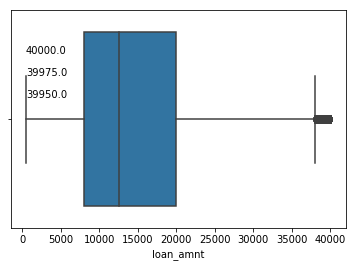

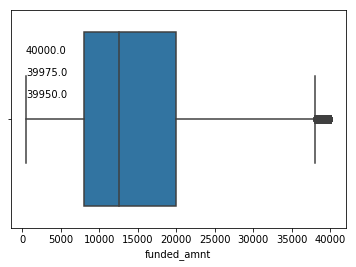

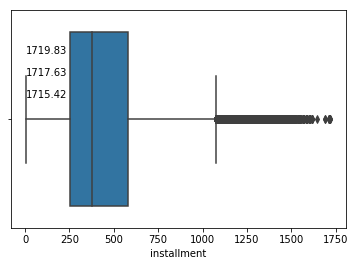

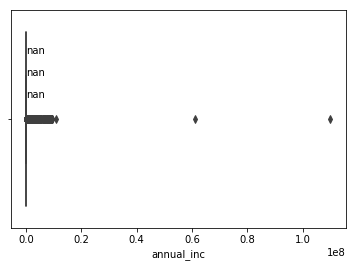

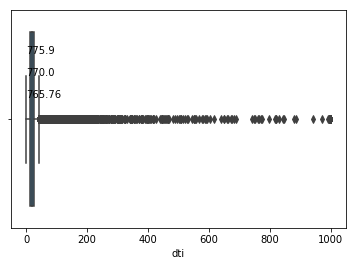

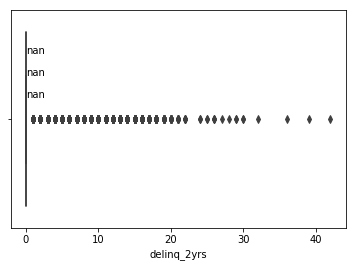

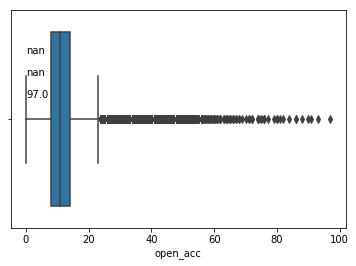

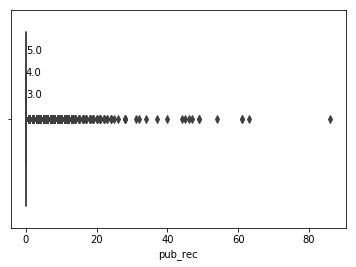

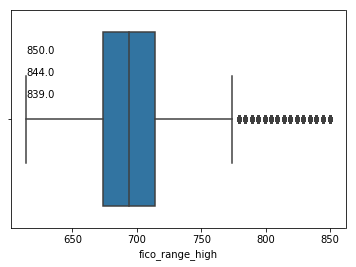

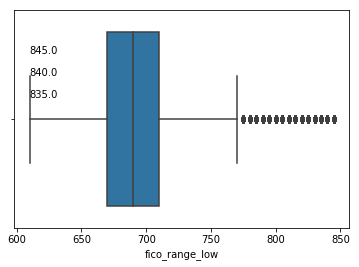

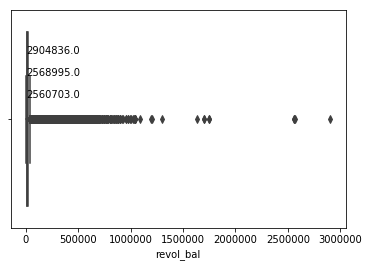

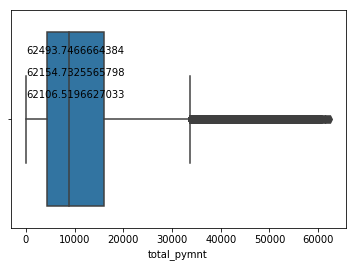

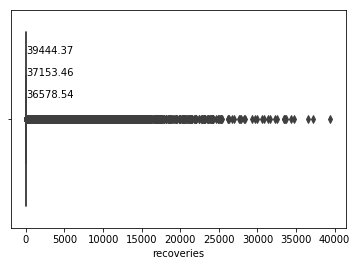

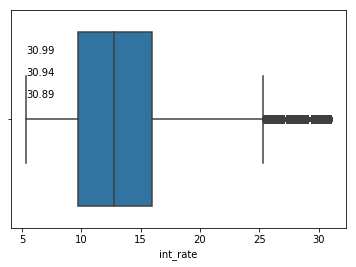

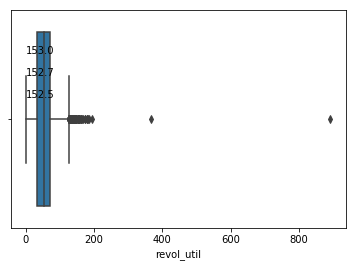

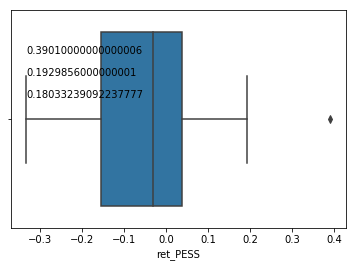

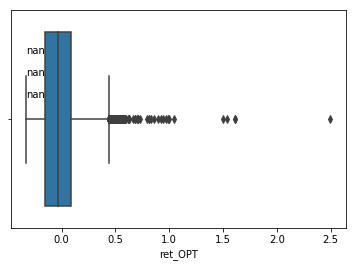

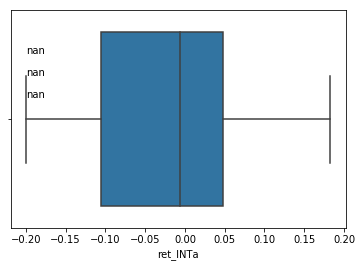

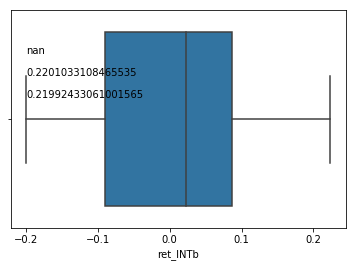

term
[' 36 months' ' 60 months']
 36 months    1260610
 60 months     498598
Name: term, dtype: int64


grade
['B' 'C' 'A' 'E' 'F' 'D' 'G']
C    521315
B    520527
A    296996
D    254390
E    116174
F     38424
G     11382
Name: grade, dtype: int64


emp_length
['10+ years' '< 1 year' '1 year' '3 years' '8 years' '9 years' '4 years'
 '5 years' '6 years' '2 years' '7 years' 'None']
10+ years    585453
2 years      158386
< 1 year     145876
3 years      139611
1 year       114808
5 years      108455
4 years      105001
None         104536
6 years       80425
8 years       75648
7 years       74482
9 years       66527
Name: emp_length, dtype: int64


home_ownership
['RENT' 'OWN' 'MORTGAGE' 'OTHER' 'NONE' 'ANY']
MORTGAGE    869367
RENT        697215
OWN         191886
ANY            504
OTHER          182
NONE            54
Name: home_ownership, dtype: int64


verification_status
['Verified' 'Source Verified' 'Not Verified']
Source Verified    668294
Not Verified       561817
Verified   

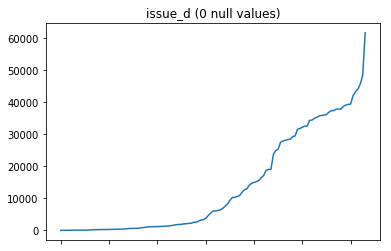

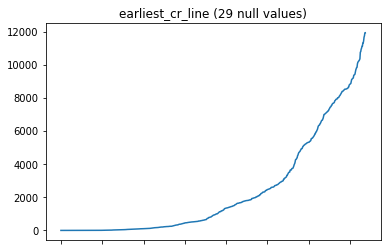

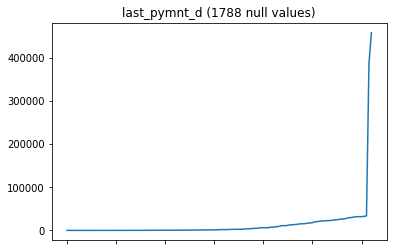

In [30]:
# visualize continuous features
visualize_float_columns()

# visulaize categorical features
visualize_cat_columns()

# visualize date columns
visualize_date_columns()

### Handle outliers

In [31]:
# There are quite a few outliers. 
# Please identify top-k (decide this based on the visualization) features where outliers are most obvious


# We chose to use 2 standard deviations when removing outliers because this allows us to keep 95% of the data while removing
# the top and bottom 2.5% of data. 2 standard deviations is also in keeping with many industry and academic standards.


n_rows = len(final_data)

# annual_inc
target = final_data.annual_inc
mean = target.mean()
sd = target.std()
final_data = final_data[(target > mean - 2*sd) & (target < mean + 2*sd)]

# installment
target = final_data.installment
mean = target.mean()
sd = target.std()
final_data = final_data[(target > mean - 2*sd) & (target < mean + 2*sd)]

# dti
target = final_data.dti
mean = target.mean()
sd = target.std()
final_data = final_data[(target > mean - 2*sd) & (target < mean + 2*sd)]

# revol_util
target = final_data.revol_util
mean = target.mean()
sd = target.std()
final_data = final_data[(target > mean - 2*sd) & (target < mean + 2*sd)]

# revol_bal
target = final_data.revol_bal
mean = target.mean()
sd = target.std()
final_data = final_data[(target > mean - 2*sd) & (target < mean + 2*sd)]

print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 181624 rows


In [32]:
len(final_data)

1577584

In [33]:
# Remove all loans that are still current
n_rows = len(final_data)

final_data = final_data[final_data.loan_status != 'Current']

print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 702383 rows


In [34]:
# Only include loans isssued since 2010
n_rows = len(final_data)

final_data = final_data[final_data.issue_d > datetime.datetime.strptime( 'Jan-2010', "%b-%Y").date()]

print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 7683 rows


### Drop null values

In [35]:
# Deal with null values. We allow cateogrical variables to be null
# OTHER than grade, which is a particularly important categorical.
# All non-categorical variables must be non-null, and we drop
# rows that do not meet this requirement

required_cols = set(cols_to_pick) - set(cat_cols) - set(["id"])
required_cols.add("grade")

n_rows = len(final_data)
final_data = final_data.dropna(subset=required_cols, how='any') # drop rows that contain null based only on "required_cols"

print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 1416 rows


In [36]:
len(final_data)

866102

### Visualize clean data

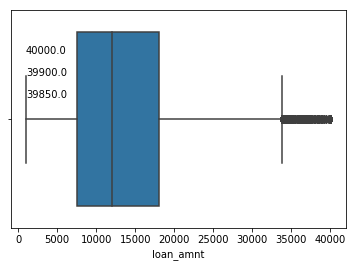

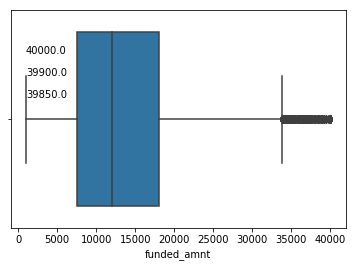

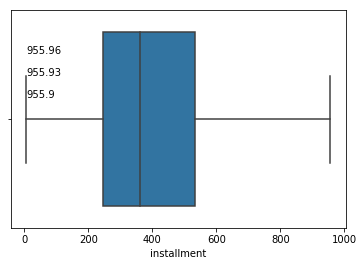

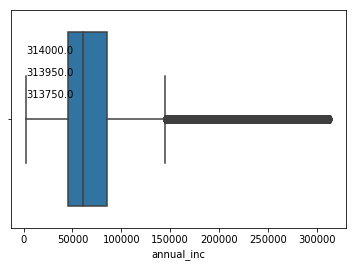

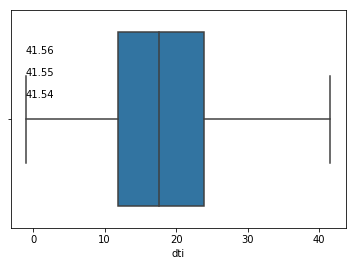

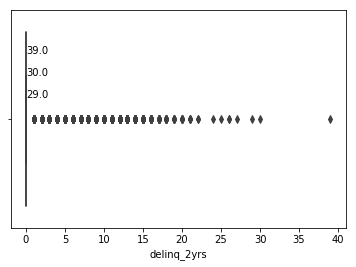

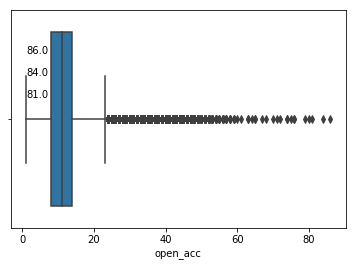

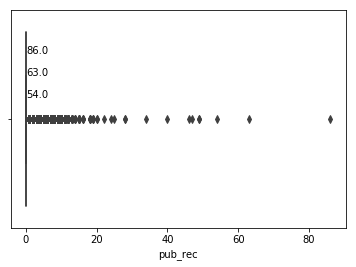

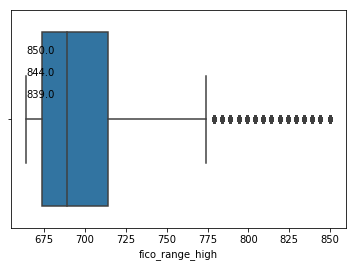

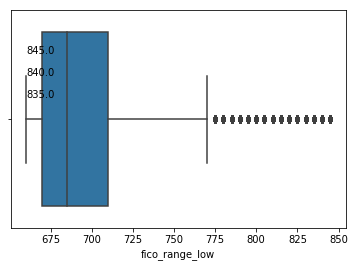

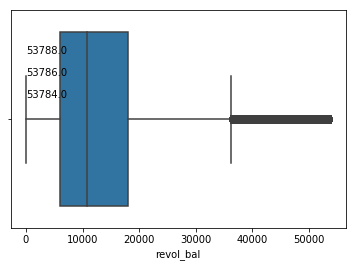

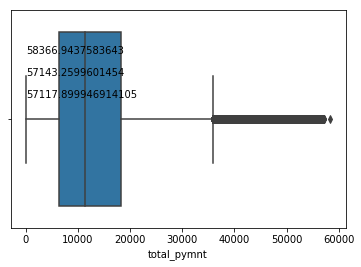

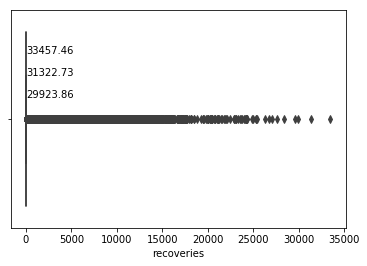

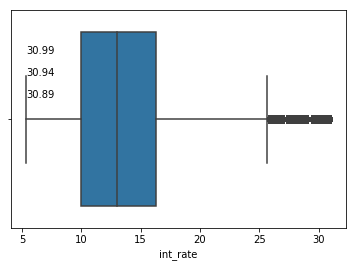

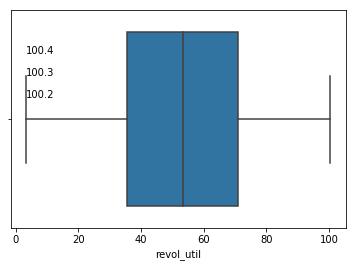

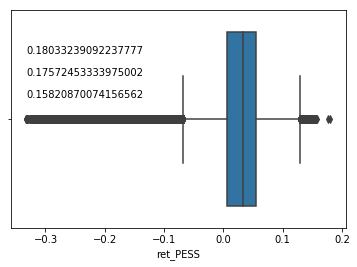

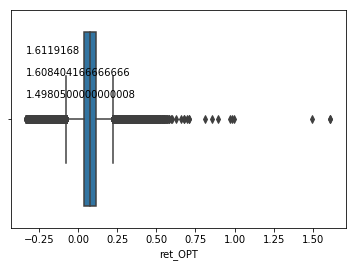

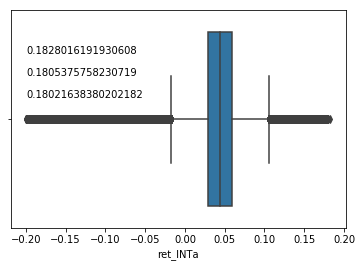

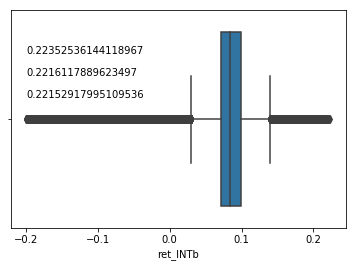

term
[' 36 months' ' 60 months']
 36 months    648408
 60 months    217694
Name: term, dtype: int64


grade
['B' 'C' 'A' 'E' 'F' 'D' 'G']
B    251770
C    245813
A    140210
D    134908
E     65563
F     22182
G      5656
Name: grade, dtype: int64


emp_length
['10+ years' '< 1 year' '1 year' '3 years' '8 years' '9 years' '4 years'
 '5 years' '6 years' '2 years' '7 years' 'None']
10+ years    277550
2 years       79001
3 years       69624
< 1 year      68785
1 year        57370
5 years       55357
4 years       52242
None          47871
6 years       42407
7 years       41123
8 years       41012
9 years       33760
Name: emp_length, dtype: int64


home_ownership
['RENT' 'OWN' 'MORTGAGE' 'OTHER' 'NONE' 'ANY']
MORTGAGE    418737
RENT        358979
OWN          88186
ANY            116
OTHER           44
NONE            40
Name: home_ownership, dtype: int64


verification_status
['Verified' 'Source Verified' 'Not Verified']
Source Verified    322225
Not Verified       276776
Verified     

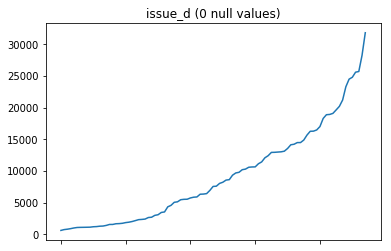

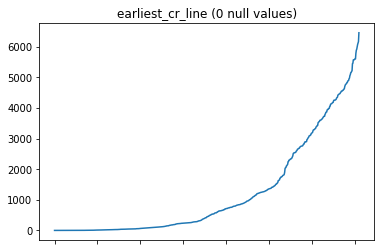

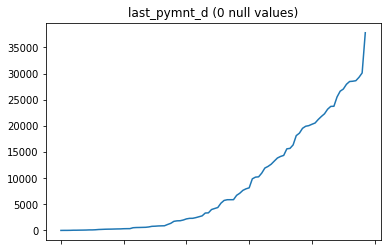

In [37]:
# Visualize the data again after cleaning

# visualize continuous features
visualize_float_columns()

# visulaize categorical features
visualize_cat_columns()

# visualize date columns
visualize_date_columns()

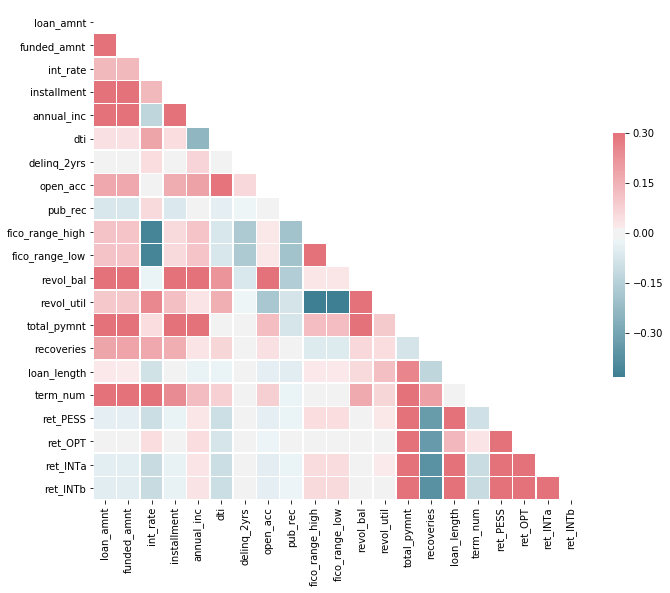

In [38]:
# Visualize the feature correlations
import seaborn as sns
import matplotlib.pyplot as plt

corr = final_data.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

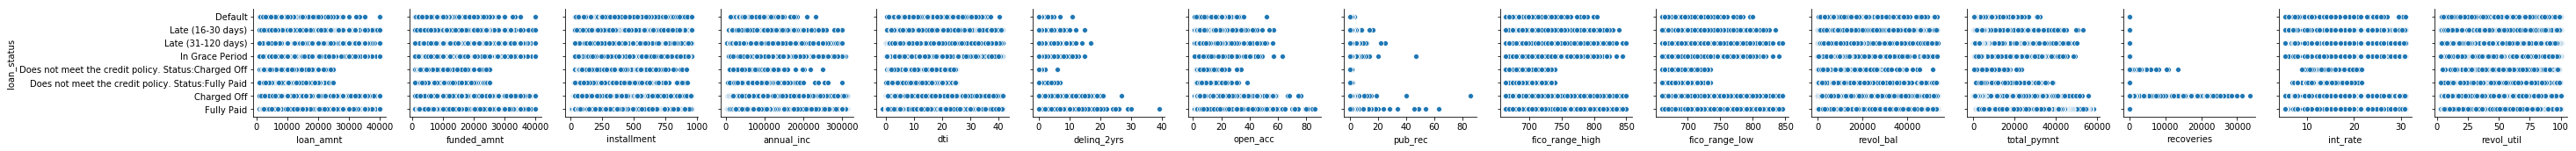

In [46]:
# Visualize relation between loan status and features
# sns pairplot or scatter plot. Refer to recitations

f, ax = plt.subplots(figsize=(11, 9))
pp = sns.pairplot(data=final_data, y_vars=["loan_status"], x_vars=continuous_features)
plt.plot()

What do you observe after removing the outliers?

We observe that the interquartile range is easier to read and interpret the variables for which we removed outliers. We can also see that the correlations are more accurate, as they are less impacted by noisy data.

### Data Exploration
Solution to Q.7 from the handout

In [52]:
# Find the percentage of loans by grade, the default by grade,
# and the return of each grade
perc_by_grade = (final_data.grade.value_counts()*100/len(final_data)).sort_index()

default_by_grade = final_data.groupby("grade").apply(lambda x : (x.loan_status != "Fully Paid").sum()*100/len(x) )
ret_by_grade_OPT = final_data.groupby("grade").apply(lambda x : (x.ret_OPT.mean())*100 ) # average return for M2-Optimistic for each loan grade
ret_by_grade_PESS = final_data.groupby("grade").apply(lambda x : (x.ret_PESS.mean())*100 ) # average return for M1-Pessimistic for each loan grade
ret_by_grade_INTa = final_data.groupby("grade").apply(lambda x : (x.ret_INTa.mean())*100 ) # average return for M3
ret_by_grade_INTb = final_data.groupby("grade").apply(lambda x : (x.ret_INTb.mean())*100 ) # average return for M3
int_rate_by_grade = final_data.groupby("grade").apply(lambda x : (x.int_rate.mean()) ) # average interest rate for each grade

combined = pd.DataFrame(perc_by_grade)
combined.columns = ['perc_of_loans']
combined['perc_default'] = default_by_grade
combined['avg_int_rate'] = int_rate_by_grade
combined['return_OPT'] = ret_by_grade_OPT
combined['return_PESS'] = ret_by_grade_PESS
combined['return_INTa'] = ret_by_grade_INTa
combined['return_INTb'] = ret_by_grade_INTb

combined

,perc_of_loans,perc_default,avg_int_rate,return_OPT,return_PESS,return_INTa,return_INTb
A,16.188624,7.561515,7.225207,3.664407,1.496678,3.027681,6.629264
B,29.069324,15.917703,10.853636,4.515496,1.191031,2.835891,6.423655
C,28.381530,26.238645,14.072595,4.584728,0.022826,1.995247,5.482542
D,15.576456,34.339698,17.562324,4.874987,-0.483976,1.517825,4.915125
E,7.569894,42.957156,20.724247,5.075359,-1.321872,0.698769,3.964543
F,2.561130,48.719683,24.496980,5.580816,-1.705888,0.237162,3.428820
G,0.653041,54.278642,27.135099,4.976075,-3.280859,-1.129926,1.913696


In [53]:
default_by_grade = final_data.groupby("grade").apply(lambda x : (x.loan_status != "Fully Paid").sum()*100/len(x) )
default_by_grade

grade
A     7.561515
B    15.917703
C    26.238645
D    34.339698
E    42.957156
F    48.719683
G    54.278642
dtype: float64

Based on the output of previous cell, write down your answers to Q.7 from the handout.

### Save a Pickle

In [54]:
# Remove the "total_pymnt" and "recoveries" from the list of continuous features
continuous_features = set(continuous_features) - set(["total_pymnt"]) - set(["recoveries"])

Why did we remove `total_pymt` and `recoveries` from the data for the task of predicting whether to give loan or not, although these are highly predictive features?

We removed these features because the value of total_pymnt and recoveries is not known at the time of making predictions on which loans to invest in. 

In [55]:
# save the prepared data for modeling in next Phase.
pickle.dump( [final_data, discrete_features, continuous_features, ret_cols], open(pickle_file, "wb") )